# Demo: Calibration Directly using Simulator (no emulator in MCMC)

- Author: Arthur Lui
- Email: alui@lanl.gov
- Date: 18 Feb, 2022

WIP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sepia
from sepia import SepiaData, SepiaModel
from sepia.contrib import emufree_calib_model
from scipy.linalg import block_diag
from sepia.contrib.ppl import distributions as dist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Simulator gridsize.
sim_gridsize = 60

# Simulator grid.
sim_grid = np.linspace(0, 1, sim_gridsize)

# Simulator.
def eta(x, t):
    return t[0] + 0.25 * np.sin(sim_grid * 4 * np.pi) * x[0]
# Discrepancy.
def delta(x, a=3):
    return np.clip(sim_grid - np.power(x[0], 0.2), 0, np.inf) * np.sqrt(x[0] * a)

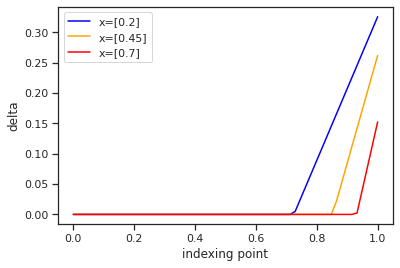

In [4]:
# Generate data.
np.random.seed(0)

num_obs = 3
xs = np.linspace(.2, .7, num_obs)[:, None]
theta = np.array([.7])
lam_true = 0.01
a = 7

colors = ["blue", "orange", "red"]
true_discrepancy = [delta(x, a=a) for x in xs]
ys = [np.random.normal(eta(x, theta) + delta(x, a=a), lam_true) for x in xs]  # TODO: wrong?
y = np.concatenate(ys)

for i, x in enumerate(xs):
    plt.plot(sim_grid, true_discrepancy[i], label=f"x={x}", color=colors[i])
plt.legend()
plt.xlabel("indexing point")
plt.ylabel("delta")
plt.show()

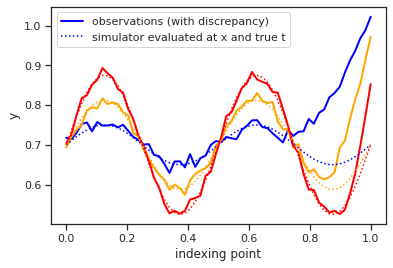

In [5]:
for i, x in enumerate(xs):
    # plt.plot(sim_grid, ys[i], lw=3)
    label = None if i > 0 else "observations (with discrepancy)"
    plt.plot(sim_grid, ys[i], label=label, lw=2, color=colors[i])
for i, x in enumerate(xs):
    label = None if i > 0 else "simulator evaluated at x and true t"
    plt.plot(sim_grid, eta(x, theta), label=label, ls=":", color=colors[i])
plt.xlabel("indexing point")
plt.ylabel("y")
plt.legend()
plt.show()

In [6]:
# Base sepia data.
# TODO: sim_grid should be in SepiaData, I think y_obs_ind?
sepia_data = SepiaData(x_obs=xs, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))

# Create D basis.
# TODO: Allow user to specify some basic bases (e.g. Gaussian kernels, linear, constant, hinge).
num_basis = 21
knots = np.linspace(0, 1, num_basis)
def make_D(knots, num_obs):
    num_basis = knots.shape[0]
    return block_diag(*[
        dist.Normal(knots[None, :], 1/(num_basis-1)).pdf(sim_grid[:, None])
        for _ in range(num_obs)
    ])
D = make_D(knots, num_obs)

sepia_data.create_D_basis(D_obs=D, num_basis=num_basis)

In [7]:
sepia_model = SepiaModel(sepia_data)

In [8]:
result = sepia_model.do_mcmc(1000, burn=3000, thinning=3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:47<00:00, 126.94it/s]


In [9]:
print("result.keys(): ", result.keys())
samples = result['samples']

print("samples.keys(): ", samples.keys())

result.keys():  dict_keys(['mcmc', 'samples', 'init_state', 'kernel', 'window', 'burn', 'num_samples', 'thinning'])
samples.keys():  dict_keys(['length_scale', 'process_sd', 't', 'lam'])


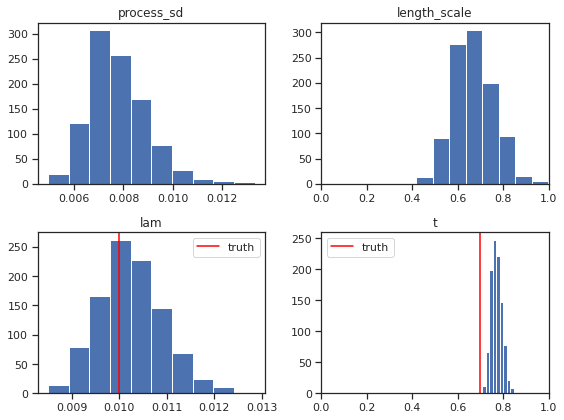

In [10]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.hist(samples["process_sd"])
plt.title("process_sd")

plt.subplot(2, 2, 2)
plt.hist(samples['length_scale'])
plt.title("length_scale")
plt.xlim(0, 1)

plt.subplot(2, 2, 3)
plt.hist(samples['lam'])
plt.title("lam")
plt.axvline(lam_true, color="red", label="truth")
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(samples["t"].flatten())
plt.title("t")
plt.xlim(0, 1)
plt.axvline(theta, color="red", label="truth")
plt.legend()

plt.tight_layout()
plt.show()

***

## TODO

18 Feb, 2022.
- [ ] Allow user to specify `sim_grid` in `SepiaData`
- [ ] Allow user to specify a bases form for `D` (e.g. hinges, constant, linear, Gaussian kernel)
- [ ] posterior predictive method, optionally at new locations (`xs`).
- [ ] posterior distribution of discrepancy (`delta`), optionally at new locations (`xs`).

In [19]:
class GP:
    def __init__(self, cov_fn, mean_fn=None):
        self.cov_fn = cov_fn
        self.mean_fn = mean_fn
        self.X = None
        self.nugget = None

    def compute_mean(self, X):
        if self.mean_fn is None:
            return np.zeros(X.shape[0])
        else:
            return self.mean_fn(X)

    def __call__(self, X, nugget=0):
        cov = self.cov_fn(X)
        self.nugget = nugget
        self.X = X
        self.dim = self.X.shape[0]
        mean = self.compute_mean(self.X)
        return dist.MvNormal(mean=mean, cov=cov + self.nugget)

    def posterior(self, X, y, Xnew, cov_obs=0):
        dim = y.shape[0]
        X_all = np.concatenate([Xnew, X])
        K_all = self.cov_fn(X_all)
        K_old = K_all[-dim:, -dim:] + cov_obs
        K_new = K_all[:-dim, :-dim]
        G = K_all[-dim:, :-dim]
        C = np.linalg.solve(K_old, G).T
        mu = self.compute_mean(X_all)
        mu_new = mu[:-dim]
        mu_old = mu[-dim:]

        return dist.MvNormal(
            mean=mu_new + C @ (y - mu_old),
            cov=K_new - C @ G
        )

In [20]:
from scipy.spatial import distance
def sqexpkernel(X, length_scale, process_sd):
    D2 = distance.cdist(X, X, metric="sqeuclidean")
    return (process_sd ** 2) * np.exp(-D2 / length_scale ** 2)

In [42]:
def make_cov(X, length_scale, process_sd):
    Sigma = np.kron(
        sqexpkernel(
            X,
            length_scale=length_scale,
            process_sd=process_sd
        ),
        np.eye(num_basis)
    )
    
    D = make_D(knots, len(X))
    marg_cov = D @ Sigma @ D.T # + lam ** 2 * np.eye(D.shape[0])
    
    return marg_cov

def make_mean(X, t):
    return np.concatenate([
        eta(x, t)
        for x in X
    ])

def mean_fn(X):
    return make_mean(X, t=samples["t"].mean(0))

def cov_fn(X):
    return make_cov(
        X,
        length_scale=samples["length_scale"].mean(),
        process_sd=samples['process_sd'].mean(),
    )

In [43]:
# TODO: Need to do this for each posterior sample.
gp = GP(cov_fn=cov_fn, mean_fn=mean_fn)
xnew = np.sort(np.concatenate([xs.flatten(), np.linspace(0, 1, 30)]))[:, None]
cov_obs = cov_obs = samples["lam"].mean(0) ** 2 * np.eye(y.shape[0])
post = gp.posterior(X=xs, y=y, Xnew=xnew, cov_obs=cov_obs)

# TODO: Need to do this for discrepancy only also.
# Get by subtracting off eta.

In [44]:
post.mean.shape

(1980,)

In [45]:
class Subset:
    def __init__(self, size):
        self.size = size
    def get(self, y, i):
        start = self.size * i
        end = start + self.size
        return y[start:end]

In [46]:
# Posterior Predictive Mean Function at (old and) new locations.

def make_plotter(fig):
    subset = Subset(sim_gridsize)

    def plotter(i, x):
        mean = subset.get(post.mean, i)
        
        if x in xs.tolist():
            j = np.argwhere(xs == x).flatten()[0]
            plt.scatter(sim_grid, subset.get(y, j), s=10, color="orange", label="data")
            
        plt.plot(sim_grid, mean, lw=3, label="prediction")
        plt.plot(sim_grid, eta(x, theta) + delta(x, a=a), label="truth")

        s = np.sqrt(np.diag(post.cov))
        lower = mean - 2 * subset.get(s, i)
        upper = mean + 2 * subset.get(s, i)
        plt.fill_between(sim_grid, lower, upper, alpha=0.1, color="blue")
        plt.ylim(0.3, 1.1)
        plt.title(f"xobs: {x[0]:.3f}")
        plt.legend(loc="lower left")
        
    return plotter

# fig = plt.figure(figsize=(16, 16))
# plotter = make_plotter(fig)
# for i, x in enumerate(xnew):
#     plt.subplot(6, 6, i + 1)
#     plotter(i, x)
# plt.tight_layout()
# plt.show()

# TODO: predict the discrepancy at new locations.

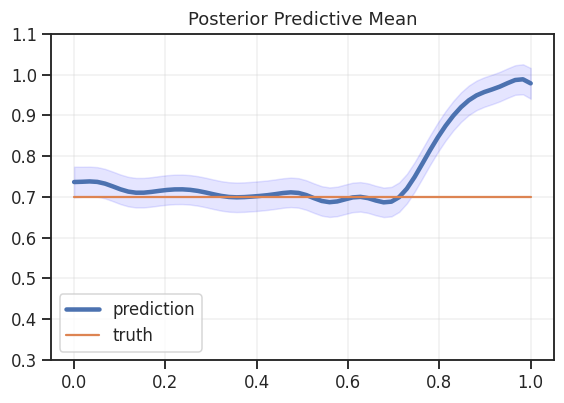

In [48]:
from matplotlib import animation
# plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.html"] = "html5"
orig_dpi = 72
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots();
plotter = make_plotter(fig)

def animate(t):
    plt.cla();
    plotter(t, xnew[t]);
    plt.grid(lw=0.3);
    plt.title("Posterior Predictive Mean")
    
def make_reversing_frames(n):
    frames = np.arange(n)
    return np.concatenate([frames, frames[::-1]])

frames = make_reversing_frames(len(xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim